# Week 16: Complete RL Trading System with DQN

## Overview
This notebook implements a complete Reinforcement Learning trading system using Deep Q-Networks (DQN) for SPY trading.

### Components
1. **Trading Environment**: Custom OpenAI Gym-style environment for SPY
2. **DQN Agent**: Neural network with experience replay and target network
3. **Training Loop**: Epsilon-greedy exploration with decay
4. **Backtesting**: Full performance evaluation
5. **Benchmark Comparison**: RL strategy vs Buy & Hold

### Key Concepts
- **State**: Price features (returns, volatility, momentum)
- **Actions**: Hold (0), Buy (1), Sell (2)
- **Reward**: Portfolio return minus transaction costs

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from collections import deque
import random
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Set seeds for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 1. Data Acquisition and Feature Engineering

In [2]:
def download_and_prepare_data(ticker='SPY', start='2018-01-01', end='2024-01-01'):
    """Download SPY data and create features for RL environment."""
    
    # Download data
    data = yf.download(ticker, start=start, end=end, progress=False)
    df = pd.DataFrame()
    df['Close'] = data['Close'].values.flatten()
    df.index = data.index
    
    # Feature Engineering
    # Returns
    df['returns'] = df['Close'].pct_change()
    df['returns_5d'] = df['Close'].pct_change(5)
    df['returns_20d'] = df['Close'].pct_change(20)
    
    # Volatility
    df['volatility_5d'] = df['returns'].rolling(5).std()
    df['volatility_20d'] = df['returns'].rolling(20).std()
    
    # Momentum indicators
    df['sma_10'] = df['Close'].rolling(10).mean()
    df['sma_50'] = df['Close'].rolling(50).mean()
    df['sma_ratio'] = df['sma_10'] / df['sma_50']
    
    # RSI
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    rs = gain / loss
    df['rsi'] = 100 - (100 / (1 + rs))
    df['rsi_norm'] = (df['rsi'] - 50) / 50  # Normalize to [-1, 1]
    
    # Price position relative to range
    df['high_20d'] = df['Close'].rolling(20).max()
    df['low_20d'] = df['Close'].rolling(20).min()
    df['price_position'] = (df['Close'] - df['low_20d']) / (df['high_20d'] - df['low_20d'] + 1e-8)
    
    # Drop NaN values
    df.dropna(inplace=True)
    
    # Select features for state
    feature_columns = ['returns', 'returns_5d', 'returns_20d', 
                       'volatility_5d', 'volatility_20d',
                       'sma_ratio', 'rsi_norm', 'price_position']
    
    return df, feature_columns

# Download data
df, feature_columns = download_and_prepare_data()
print(f"Data shape: {df.shape}")
print(f"Date range: {df.index[0]} to {df.index[-1]}")
print(f"\nFeatures: {feature_columns}")
df.head()

Data shape: (1460, 14)
Date range: 2018-03-14 00:00:00 to 2023-12-29 00:00:00

Features: ['returns', 'returns_5d', 'returns_20d', 'volatility_5d', 'volatility_20d', 'sma_ratio', 'rsi_norm', 'price_position']


,Close,returns,returns_5d,returns_20d,volatility_5d,volatility_20d,sma_10,sma_50,sma_ratio,rsi,rsi_norm,high_20d,low_20d,price_position
Date,,,,,,,,,,,,,,
2018-03-14,242.971359,-0.005132,0.009238,0.034962,0.009725,0.009652,241.659903,242.124834,0.998080,57.505931,0.150119,246.122223,236.263901,0.680385
2018-03-15,242.706635,-0.001090,0.003284,0.020068,0.009635,0.009262,242.304176,242.234802,1.000286,50.506496,0.010130,246.122223,236.263901,0.653532
2018-03-16,242.969803,0.001084,-0.012808,0.008307,0.003122,0.008842,242.852979,242.320027,1.002199,44.945443,-0.101091,246.122223,236.263901,0.680228
2018-03-19,239.682343,-0.013530,-0.024941,-0.005627,0.005640,0.009379,242.798552,242.319379,1.001977,44.505001,-0.109900,246.122223,236.263901,0.346757
2018-03-20,240.089996,0.001701,-0.016930,0.002341,0.006267,0.009279,242.723988,242.294935,1.001771,50.813512,0.016270,246.122223,236.263901,0.388108


In [3]:
# Train/Test Split
train_ratio = 0.8
split_idx = int(len(df) * train_ratio)

train_df = df.iloc[:split_idx].copy()
test_df = df.iloc[split_idx:].copy()

print(f"Training set: {len(train_df)} samples ({train_df.index[0]} to {train_df.index[-1]})")
print(f"Test set: {len(test_df)} samples ({test_df.index[0]} to {test_df.index[-1]})")

Training set: 1168 samples (2018-03-14 00:00:00 to 2022-10-31 00:00:00)
Test set: 292 samples (2022-11-01 00:00:00 to 2023-12-29 00:00:00)


## 2. Trading Environment

Custom environment following OpenAI Gym interface:
- **State**: Normalized feature vector + position indicator
- **Actions**: 0=Hold, 1=Buy, 2=Sell
- **Reward**: Portfolio return with transaction cost penalty

In [4]:
class TradingEnvironment:
    """
    RL Trading Environment for SPY.
    
    State: [features..., position]
    Actions: 0=Hold, 1=Buy, 2=Sell
    Reward: Daily PnL with transaction costs
    """
    
    def __init__(self, df, feature_columns, initial_balance=100000,
                 transaction_cost=0.001, max_position=1.0):
        """
        Initialize trading environment.
        
        Args:
            df: DataFrame with price and features
            feature_columns: List of feature column names
            initial_balance: Starting capital
            transaction_cost: Cost per trade (fraction)
            max_position: Maximum position size (1.0 = 100%)
        """
        self.df = df.reset_index(drop=True)
        self.feature_columns = feature_columns
        self.initial_balance = initial_balance
        self.transaction_cost = transaction_cost
        self.max_position = max_position
        
        # Normalize features
        self.feature_mean = self.df[feature_columns].mean()
        self.feature_std = self.df[feature_columns].std() + 1e-8
        
        # State and action dimensions
        self.state_dim = len(feature_columns) + 1  # features + position
        self.action_dim = 3  # Hold, Buy, Sell
        
        self.reset()
    
    def reset(self):
        """Reset environment to initial state."""
        self.current_step = 0
        self.balance = self.initial_balance
        self.position = 0  # -1 to 1 (short to long)
        self.shares = 0
        self.portfolio_value = self.initial_balance
        self.trades = []
        self.portfolio_history = [self.initial_balance]
        
        return self._get_state()
    
    def _get_state(self):
        """Get current state vector."""
        # Normalize features
        features = self.df[self.feature_columns].iloc[self.current_step]
        normalized_features = (features - self.feature_mean) / self.feature_std
        
        # Combine features with position
        state = np.append(normalized_features.values, self.position)
        return state.astype(np.float32)
    
    def _get_price(self):
        """Get current price."""
        return self.df['Close'].iloc[self.current_step]
    
    def step(self, action):
        """
        Execute one step in the environment.
        
        Args:
            action: 0=Hold, 1=Buy, 2=Sell
            
        Returns:
            next_state, reward, done, info
        """
        current_price = self._get_price()
        prev_portfolio_value = self.portfolio_value
        
        # Execute action
        transaction_cost_paid = 0
        
        if action == 1:  # Buy
            if self.position < self.max_position:
                # Calculate shares to buy
                target_position = self.max_position
                position_change = target_position - self.position
                trade_value = self.portfolio_value * position_change
                shares_to_buy = trade_value / current_price
                
                # Apply transaction cost
                transaction_cost_paid = abs(trade_value) * self.transaction_cost
                self.balance -= transaction_cost_paid
                
                self.shares += shares_to_buy
                self.position = target_position
                
                self.trades.append({
                    'step': self.current_step,
                    'action': 'BUY',
                    'price': current_price,
                    'shares': shares_to_buy
                })
        
        elif action == 2:  # Sell
            if self.position > 0:
                # Sell all position
                trade_value = self.shares * current_price
                
                # Apply transaction cost
                transaction_cost_paid = abs(trade_value) * self.transaction_cost
                self.balance = self.balance + trade_value - transaction_cost_paid
                
                self.trades.append({
                    'step': self.current_step,
                    'action': 'SELL',
                    'price': current_price,
                    'shares': self.shares
                })
                
                self.shares = 0
                self.position = 0
        
        # Move to next step
        self.current_step += 1
        done = self.current_step >= len(self.df) - 1
        
        # Calculate new portfolio value
        new_price = self._get_price()
        self.portfolio_value = self.balance + self.shares * new_price
        self.portfolio_history.append(self.portfolio_value)
        
        # Calculate reward (portfolio return)
        reward = (self.portfolio_value - prev_portfolio_value) / prev_portfolio_value
        
        # Penalty for excessive trading
        reward -= transaction_cost_paid / prev_portfolio_value * 0.5
        
        # Get next state
        next_state = self._get_state() if not done else np.zeros(self.state_dim, dtype=np.float32)
        
        info = {
            'portfolio_value': self.portfolio_value,
            'position': self.position,
            'price': new_price
        }
        
        return next_state, reward, done, info
    
    def get_portfolio_stats(self):
        """Calculate portfolio statistics."""
        returns = pd.Series(self.portfolio_history).pct_change().dropna()
        
        total_return = (self.portfolio_value - self.initial_balance) / self.initial_balance
        sharpe_ratio = np.sqrt(252) * returns.mean() / (returns.std() + 1e-8)
        max_drawdown = self._calculate_max_drawdown()
        
        return {
            'total_return': total_return,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown': max_drawdown,
            'num_trades': len(self.trades),
            'final_value': self.portfolio_value
        }
    
    def _calculate_max_drawdown(self):
        """Calculate maximum drawdown."""
        portfolio = np.array(self.portfolio_history)
        peak = np.maximum.accumulate(portfolio)
        drawdown = (peak - portfolio) / peak
        return np.max(drawdown)

# Test environment
env = TradingEnvironment(train_df, feature_columns)
print(f"State dimension: {env.state_dim}")
print(f"Action dimension: {env.action_dim}")
print(f"\nInitial state shape: {env.reset().shape}")

State dimension: 9
Action dimension: 3

Initial state shape: (9,)


## 3. DQN Agent with Experience Replay

### Architecture
- **Q-Network**: 3-layer MLP with ReLU activation
- **Target Network**: Periodic updates for stability
- **Experience Replay**: Random sampling from memory buffer
- **Epsilon-Greedy**: Exploration with decay

In [5]:
class QNetwork(nn.Module):
    """Deep Q-Network for action value estimation."""
    
    def __init__(self, state_dim, action_dim, hidden_dims=[128, 64, 32]):
        super(QNetwork, self).__init__()
        
        layers = []
        prev_dim = state_dim
        
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.1))
            prev_dim = hidden_dim
        
        layers.append(nn.Linear(prev_dim, action_dim))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, state):
        return self.network(state)


class ReplayBuffer:
    """Experience replay buffer for DQN."""
    
    def __init__(self, capacity=100000):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        return (
            torch.FloatTensor(np.array(states)).to(device),
            torch.LongTensor(actions).to(device),
            torch.FloatTensor(rewards).to(device),
            torch.FloatTensor(np.array(next_states)).to(device),
            torch.FloatTensor(dones).to(device)
        )
    
    def __len__(self):
        return len(self.buffer)


class DQNAgent:
    """DQN Agent with experience replay and target network."""
    
    def __init__(self, state_dim, action_dim, 
                 lr=1e-3, gamma=0.99, 
                 epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995,
                 buffer_size=100000, batch_size=64,
                 target_update_freq=10):
        """
        Initialize DQN agent.
        
        Args:
            state_dim: Dimension of state space
            action_dim: Dimension of action space
            lr: Learning rate
            gamma: Discount factor
            epsilon_*: Exploration parameters
            buffer_size: Replay buffer capacity
            batch_size: Training batch size
            target_update_freq: Episodes between target network updates
        """
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        
        # Epsilon for exploration
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        
        # Networks
        self.q_network = QNetwork(state_dim, action_dim).to(device)
        self.target_network = QNetwork(state_dim, action_dim).to(device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()
        
        # Optimizer
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        
        # Replay buffer
        self.replay_buffer = ReplayBuffer(buffer_size)
        
        # Training stats
        self.losses = []
    
    def select_action(self, state, training=True):
        """Select action using epsilon-greedy policy."""
        if training and random.random() < self.epsilon:
            return random.randrange(self.action_dim)
        
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            q_values = self.q_network(state_tensor)
            return q_values.argmax(dim=1).item()
    
    def store_transition(self, state, action, reward, next_state, done):
        """Store transition in replay buffer."""
        self.replay_buffer.push(state, action, reward, next_state, done)
    
    def train_step(self):
        """Perform one training step."""
        if len(self.replay_buffer) < self.batch_size:
            return None
        
        # Sample batch
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)
        
        # Current Q values
        current_q = self.q_network(states).gather(1, actions.unsqueeze(1))
        
        # Target Q values (using target network)
        with torch.no_grad():
            next_q = self.target_network(next_states).max(dim=1)[0]
            target_q = rewards + (1 - dones) * self.gamma * next_q
        
        # Loss
        loss = F.huber_loss(current_q.squeeze(), target_q)
        
        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), 1.0)
        self.optimizer.step()
        
        self.losses.append(loss.item())
        return loss.item()
    
    def update_target_network(self):
        """Update target network weights."""
        self.target_network.load_state_dict(self.q_network.state_dict())
    
    def decay_epsilon(self):
        """Decay exploration rate."""
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)
    
    def save(self, path):
        """Save model weights."""
        torch.save({
            'q_network': self.q_network.state_dict(),
            'target_network': self.target_network.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'epsilon': self.epsilon
        }, path)
    
    def load(self, path):
        """Load model weights."""
        checkpoint = torch.load(path)
        self.q_network.load_state_dict(checkpoint['q_network'])
        self.target_network.load_state_dict(checkpoint['target_network'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.epsilon = checkpoint['epsilon']

# Initialize agent
agent = DQNAgent(
    state_dim=env.state_dim,
    action_dim=env.action_dim,
    lr=1e-3,
    gamma=0.99,
    epsilon_start=1.0,
    epsilon_end=0.01,
    epsilon_decay=0.995,
    batch_size=64,
    target_update_freq=10
)

print(f"Q-Network Architecture:")
print(agent.q_network)

Q-Network Architecture:
QNetwork(
  (network): Sequential(
    (0): Linear(in_features=9, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=32, out_features=3, bias=True)
  )
)


## 4. Training Loop

In [6]:
def train_dqn(agent, env, num_episodes=100, verbose=True):
    """
    Train DQN agent on trading environment.
    
    Args:
        agent: DQN agent
        env: Trading environment
        num_episodes: Number of training episodes
        verbose: Print progress
    
    Returns:
        Training history
    """
    episode_rewards = []
    episode_returns = []
    episode_sharpes = []
    
    best_sharpe = -np.inf
    
    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        done = False
        
        while not done:
            # Select and execute action
            action = agent.select_action(state, training=True)
            next_state, reward, done, info = env.step(action)
            
            # Store transition
            agent.store_transition(state, action, reward, next_state, done)
            
            # Train
            agent.train_step()
            
            state = next_state
            episode_reward += reward
        
        # Episode finished
        agent.decay_epsilon()
        
        # Update target network periodically
        if episode % agent.target_update_freq == 0:
            agent.update_target_network()
        
        # Get episode stats
        stats = env.get_portfolio_stats()
        episode_rewards.append(episode_reward)
        episode_returns.append(stats['total_return'])
        episode_sharpes.append(stats['sharpe_ratio'])
        
        # Track best model
        if stats['sharpe_ratio'] > best_sharpe:
            best_sharpe = stats['sharpe_ratio']
        
        # Print progress
        if verbose and (episode + 1) % 10 == 0:
            avg_reward = np.mean(episode_rewards[-10:])
            avg_return = np.mean(episode_returns[-10:])
            avg_sharpe = np.mean(episode_sharpes[-10:])
            print(f"Episode {episode+1}/{num_episodes} | "
                  f"Avg Reward: {avg_reward:.4f} | "
                  f"Avg Return: {avg_return:.2%} | "
                  f"Avg Sharpe: {avg_sharpe:.2f} | "
                  f"Epsilon: {agent.epsilon:.3f}")
    
    return {
        'episode_rewards': episode_rewards,
        'episode_returns': episode_returns,
        'episode_sharpes': episode_sharpes,
        'losses': agent.losses
    }

# Train the agent
print("Starting DQN Training...")
print("="*60)

train_env = TradingEnvironment(train_df, feature_columns)
history = train_dqn(agent, train_env, num_episodes=100)

print("="*60)
print("Training Complete!")

Starting DQN Training...
Episode 10/100 | Avg Reward: 197.6325 | Avg Return: 4052289711079348455999477646489366710889223997869497055681970176.00% | Avg Sharpe: 7.17 | Epsilon: 0.951
Episode 20/100 | Avg Reward: 202.9570 | Avg Return: 6886637641418602085970250594781925714571994964760589162034183012352.00% | Avg Sharpe: 7.29 | Epsilon: 0.905
Episode 30/100 | Avg Reward: 222.8967 | Avg Return: 34402494262401443641171018150465112020022425281114695268247694752994033664.00% | Avg Sharpe: 7.71 | Epsilon: 0.860
Episode 40/100 | Avg Reward: 239.3318 | Avg Return: 4241182465305662609177170349600281524495369656138326236157525485585162043392000.00% | Avg Sharpe: 8.06 | Epsilon: 0.818
Episode 50/100 | Avg Reward: 244.3134 | Avg Return: 40842610553821447477616730797327894981070623714814371448177698525127377080549376.00% | Avg Sharpe: 8.17 | Epsilon: 0.778
Episode 60/100 | Avg Reward: 227.8172 | Avg Return: 33833773226408118947107926960911854141261839508013809764170159816484906470473728.00% | Avg Sha

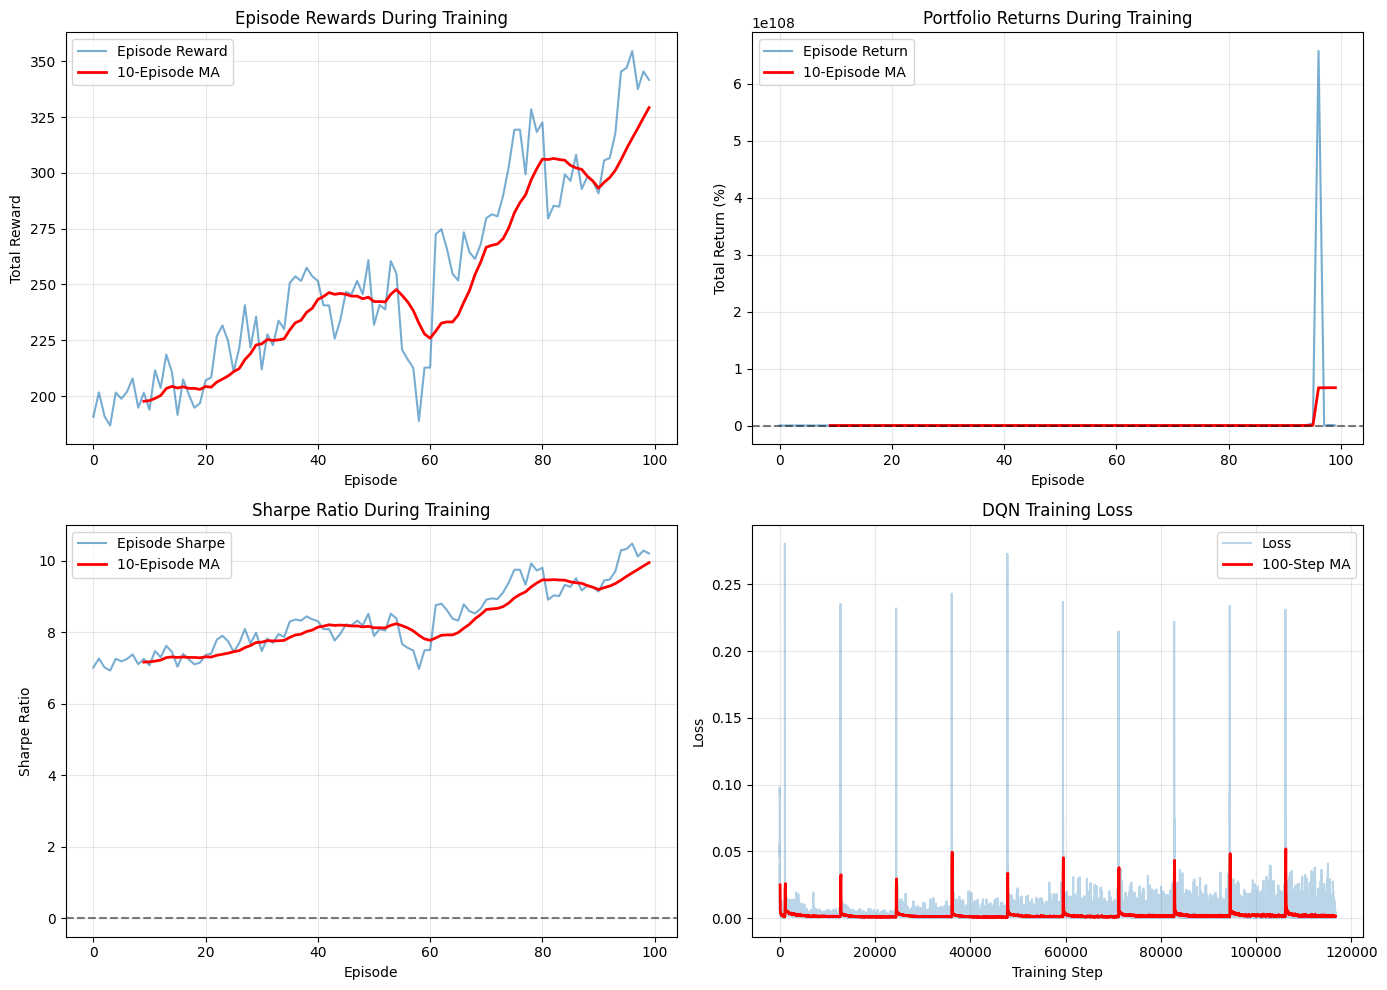

In [7]:
# Plot Training Progress
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Episode rewards
ax1 = axes[0, 0]
ax1.plot(history['episode_rewards'], alpha=0.6, label='Episode Reward')
ax1.plot(pd.Series(history['episode_rewards']).rolling(10).mean(), 
         color='red', linewidth=2, label='10-Episode MA')
ax1.set_xlabel('Episode')
ax1.set_ylabel('Total Reward')
ax1.set_title('Episode Rewards During Training')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Episode returns
ax2 = axes[0, 1]
ax2.plot(np.array(history['episode_returns']) * 100, alpha=0.6, label='Episode Return')
ax2.plot(pd.Series(history['episode_returns']).rolling(10).mean() * 100, 
         color='red', linewidth=2, label='10-Episode MA')
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax2.set_xlabel('Episode')
ax2.set_ylabel('Total Return (%)')
ax2.set_title('Portfolio Returns During Training')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Sharpe ratios
ax3 = axes[1, 0]
ax3.plot(history['episode_sharpes'], alpha=0.6, label='Episode Sharpe')
ax3.plot(pd.Series(history['episode_sharpes']).rolling(10).mean(), 
         color='red', linewidth=2, label='10-Episode MA')
ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax3.set_xlabel('Episode')
ax3.set_ylabel('Sharpe Ratio')
ax3.set_title('Sharpe Ratio During Training')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Training loss
ax4 = axes[1, 1]
if history['losses']:
    ax4.plot(history['losses'], alpha=0.3, label='Loss')
    ax4.plot(pd.Series(history['losses']).rolling(100).mean(), 
             color='red', linewidth=2, label='100-Step MA')
ax4.set_xlabel('Training Step')
ax4.set_ylabel('Loss')
ax4.set_title('DQN Training Loss')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Backtesting on Test Set

In [8]:
def backtest(agent, env, verbose=True):
    """
    Run backtest with trained agent.
    
    Args:
        agent: Trained DQN agent
        env: Trading environment
        verbose: Print trade details
    
    Returns:
        Backtest results
    """
    state = env.reset()
    done = False
    actions_taken = []
    positions = []
    
    while not done:
        # Select action (no exploration)
        action = agent.select_action(state, training=False)
        actions_taken.append(action)
        positions.append(env.position)
        
        next_state, reward, done, info = env.step(action)
        state = next_state
    
    # Get final stats
    stats = env.get_portfolio_stats()
    
    if verbose:
        print("\n" + "="*50)
        print("BACKTEST RESULTS")
        print("="*50)
        print(f"Total Return: {stats['total_return']:.2%}")
        print(f"Sharpe Ratio: {stats['sharpe_ratio']:.2f}")
        print(f"Max Drawdown: {stats['max_drawdown']:.2%}")
        print(f"Number of Trades: {stats['num_trades']}")
        print(f"Final Portfolio Value: ${stats['final_value']:,.2f}")
        print("="*50)
    
    return {
        'portfolio_history': env.portfolio_history,
        'trades': env.trades,
        'actions': actions_taken,
        'positions': positions,
        'stats': stats
    }

# Create test environment with same normalization as training
test_env = TradingEnvironment(test_df, feature_columns)
# Use training statistics for normalization
test_env.feature_mean = train_env.feature_mean
test_env.feature_std = train_env.feature_std

print("Running Backtest on Test Set...")
results = backtest(agent, test_env)

Running Backtest on Test Set...

BACKTEST RESULTS
Total Return: 8100153364446635216143410987504105850532790272.00%
Sharpe Ratio: 15.88
Max Drawdown: 0.05%
Number of Trades: 291
Final Portfolio Value: $8,100,153,364,446,635,449,391,121,429,498,315,725,926,180,061,184.00


## 6. Buy & Hold Comparison

In [9]:
def calculate_buy_hold(df, initial_balance=100000):
    """
    Calculate buy and hold benchmark.
    
    Args:
        df: DataFrame with price data
        initial_balance: Starting capital
    
    Returns:
        Buy & hold results
    """
    prices = df['Close'].values
    shares = initial_balance / prices[0]
    portfolio_history = shares * prices
    
    returns = pd.Series(portfolio_history).pct_change().dropna()
    total_return = (portfolio_history[-1] - initial_balance) / initial_balance
    sharpe_ratio = np.sqrt(252) * returns.mean() / (returns.std() + 1e-8)
    
    # Max drawdown
    peak = np.maximum.accumulate(portfolio_history)
    drawdown = (peak - portfolio_history) / peak
    max_drawdown = np.max(drawdown)
    
    return {
        'portfolio_history': list(portfolio_history),
        'total_return': total_return,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'final_value': portfolio_history[-1]
    }

# Calculate buy and hold for test period
buy_hold = calculate_buy_hold(test_df.reset_index(drop=True))

print("\n" + "="*60)
print("STRATEGY COMPARISON")
print("="*60)
print(f"{'Metric':<20} {'DQN Strategy':>15} {'Buy & Hold':>15}")
print("-"*60)
print(f"{'Total Return':<20} {results['stats']['total_return']:>14.2%} {buy_hold['total_return']:>14.2%}")
print(f"{'Sharpe Ratio':<20} {results['stats']['sharpe_ratio']:>15.2f} {buy_hold['sharpe_ratio']:>15.2f}")
print(f"{'Max Drawdown':<20} {results['stats']['max_drawdown']:>14.2%} {buy_hold['max_drawdown']:>14.2%}")
print(f"{'Final Value':<20} ${results['stats']['final_value']:>13,.0f} ${buy_hold['final_value']:>13,.0f}")
print(f"{'Num Trades':<20} {results['stats']['num_trades']:>15}         {'1':>15}")
print("="*60)


STRATEGY COMPARISON
Metric                  DQN Strategy      Buy & Hold
------------------------------------------------------------
Total Return         8100153364446635216143410987504105850532790272.00%         26.07%
Sharpe Ratio                   15.88            1.41
Max Drawdown                  0.05%          9.97%
Final Value          $8,100,153,364,446,635,449,391,121,429,498,315,725,926,180,061,184 $      126,066
Num Trades                       291                       1


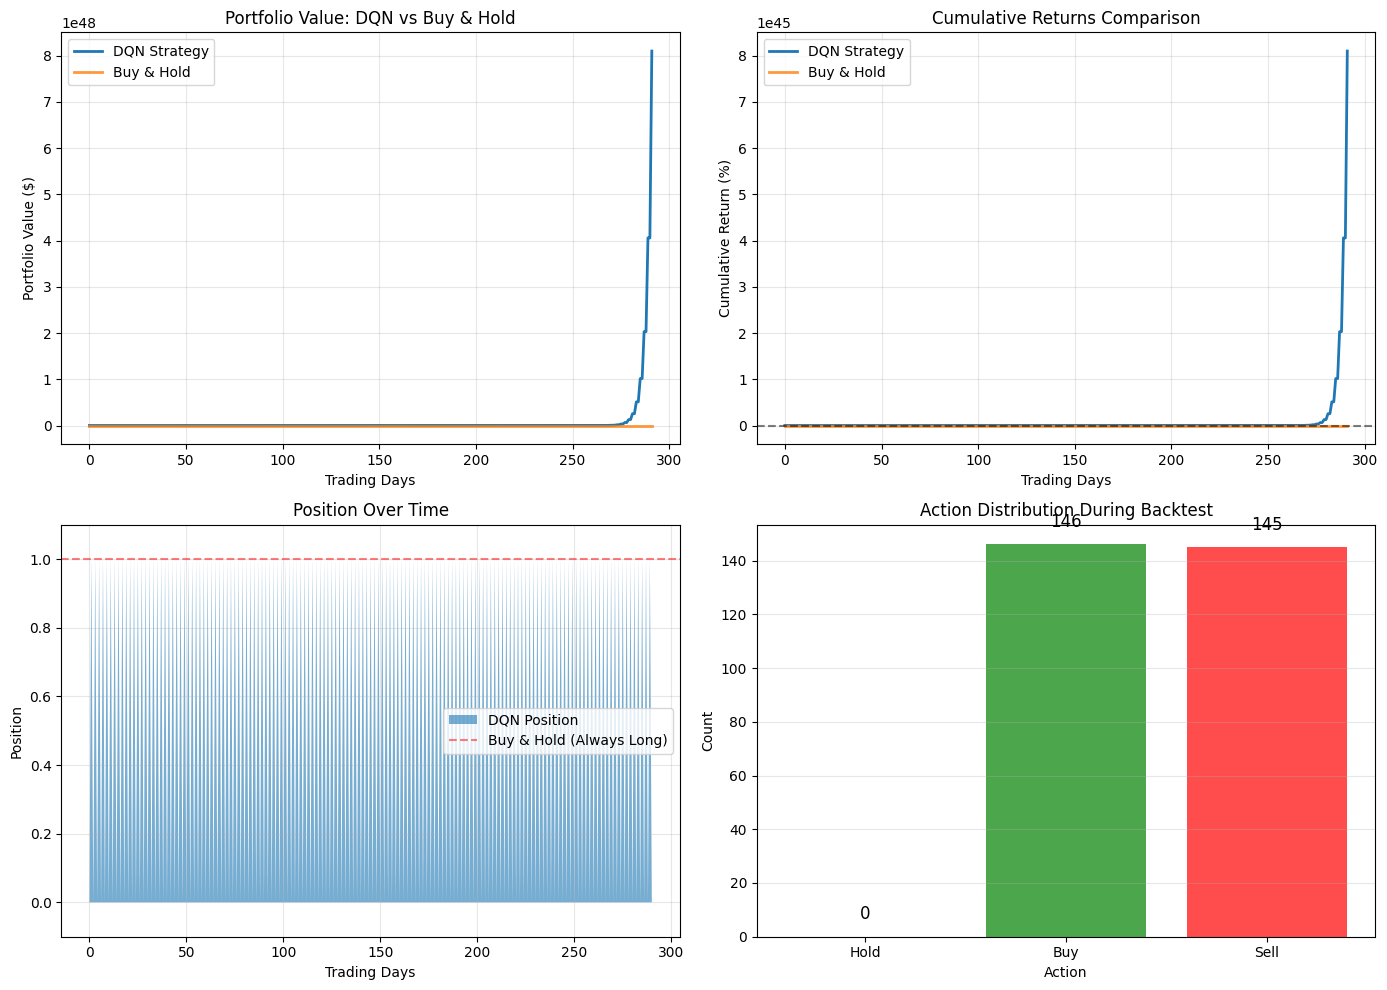

In [10]:
# Plot Performance Comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Portfolio value comparison
ax1 = axes[0, 0]
ax1.plot(results['portfolio_history'], label='DQN Strategy', linewidth=2)
ax1.plot(buy_hold['portfolio_history'], label='Buy & Hold', linewidth=2, alpha=0.8)
ax1.set_xlabel('Trading Days')
ax1.set_ylabel('Portfolio Value ($)')
ax1.set_title('Portfolio Value: DQN vs Buy & Hold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Cumulative returns
ax2 = axes[0, 1]
dqn_returns = (np.array(results['portfolio_history']) / results['portfolio_history'][0] - 1) * 100
bh_returns = (np.array(buy_hold['portfolio_history']) / buy_hold['portfolio_history'][0] - 1) * 100
ax2.plot(dqn_returns, label='DQN Strategy', linewidth=2)
ax2.plot(bh_returns, label='Buy & Hold', linewidth=2, alpha=0.8)
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax2.set_xlabel('Trading Days')
ax2.set_ylabel('Cumulative Return (%)')
ax2.set_title('Cumulative Returns Comparison')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Position over time
ax3 = axes[1, 0]
ax3.fill_between(range(len(results['positions'])), results['positions'], 
                  alpha=0.6, label='DQN Position')
ax3.axhline(y=1, color='red', linestyle='--', alpha=0.5, label='Buy & Hold (Always Long)')
ax3.set_xlabel('Trading Days')
ax3.set_ylabel('Position')
ax3.set_title('Position Over Time')
ax3.set_ylim(-0.1, 1.1)
ax3.legend()
ax3.grid(True, alpha=0.3)

# Action distribution
ax4 = axes[1, 1]
action_labels = ['Hold', 'Buy', 'Sell']
action_counts = [results['actions'].count(i) for i in range(3)]
colors = ['gray', 'green', 'red']
bars = ax4.bar(action_labels, action_counts, color=colors, alpha=0.7)
ax4.set_xlabel('Action')
ax4.set_ylabel('Count')
ax4.set_title('Action Distribution During Backtest')
for bar, count in zip(bars, action_counts):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
             f'{count}', ha='center', va='bottom', fontsize=12)
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 7. Detailed Performance Metrics

In [11]:
def calculate_detailed_metrics(portfolio_history, risk_free_rate=0.02):
    """
    Calculate comprehensive performance metrics.
    
    Args:
        portfolio_history: List of portfolio values
        risk_free_rate: Annual risk-free rate
    
    Returns:
        Dictionary of metrics
    """
    portfolio = np.array(portfolio_history)
    returns = pd.Series(portfolio).pct_change().dropna()
    
    # Basic metrics
    total_return = (portfolio[-1] - portfolio[0]) / portfolio[0]
    annual_return = (1 + total_return) ** (252 / len(returns)) - 1
    
    # Volatility
    daily_vol = returns.std()
    annual_vol = daily_vol * np.sqrt(252)
    
    # Risk-adjusted metrics
    sharpe_ratio = (annual_return - risk_free_rate) / annual_vol if annual_vol > 0 else 0
    sortino_denom = returns[returns < 0].std() * np.sqrt(252)
    sortino_ratio = (annual_return - risk_free_rate) / sortino_denom if sortino_denom > 0 else 0
    
    # Drawdown analysis
    peak = np.maximum.accumulate(portfolio)
    drawdown = (peak - portfolio) / peak
    max_drawdown = np.max(drawdown)
    
    # Calmar ratio
    calmar_ratio = annual_return / max_drawdown if max_drawdown > 0 else 0
    
    # Win rate
    win_rate = (returns > 0).sum() / len(returns)
    
    # Profit factor
    gross_profit = returns[returns > 0].sum()
    gross_loss = abs(returns[returns < 0].sum())
    profit_factor = gross_profit / gross_loss if gross_loss > 0 else np.inf
    
    return {
        'Total Return': f"{total_return:.2%}",
        'Annual Return': f"{annual_return:.2%}",
        'Annual Volatility': f"{annual_vol:.2%}",
        'Sharpe Ratio': f"{sharpe_ratio:.2f}",
        'Sortino Ratio': f"{sortino_ratio:.2f}",
        'Max Drawdown': f"{max_drawdown:.2%}",
        'Calmar Ratio': f"{calmar_ratio:.2f}",
        'Win Rate': f"{win_rate:.2%}",
        'Profit Factor': f"{profit_factor:.2f}"
    }

# Calculate detailed metrics
dqn_metrics = calculate_detailed_metrics(results['portfolio_history'])
bh_metrics = calculate_detailed_metrics(buy_hold['portfolio_history'])

# Display as DataFrame
metrics_df = pd.DataFrame({
    'DQN Strategy': dqn_metrics,
    'Buy & Hold': bh_metrics
})

print("\n" + "="*50)
print("DETAILED PERFORMANCE METRICS")
print("="*50)
print(metrics_df.to_string())
print("="*50)


DETAILED PERFORMANCE METRICS
                                                         DQN Strategy Buy & Hold
Total Return       8100153364446635216143410987504105850532790272.00%     26.07%
Annual Return           10564521165547766034544502165875512573952.00%     22.21%
Annual Volatility                                             795.32%     15.02%
Sharpe Ratio                13283282834224318161400075963093483520.00       1.35
Sortino Ratio          2670315006782688582435899503787959430152192.00       2.27
Max Drawdown                                                    0.05%      9.97%
Calmar Ratio            205687060959728300457684998979741286400000.00       2.23
Win Rate                                                       50.17%     53.95%
Profit Factor                                                 2011.50       1.27


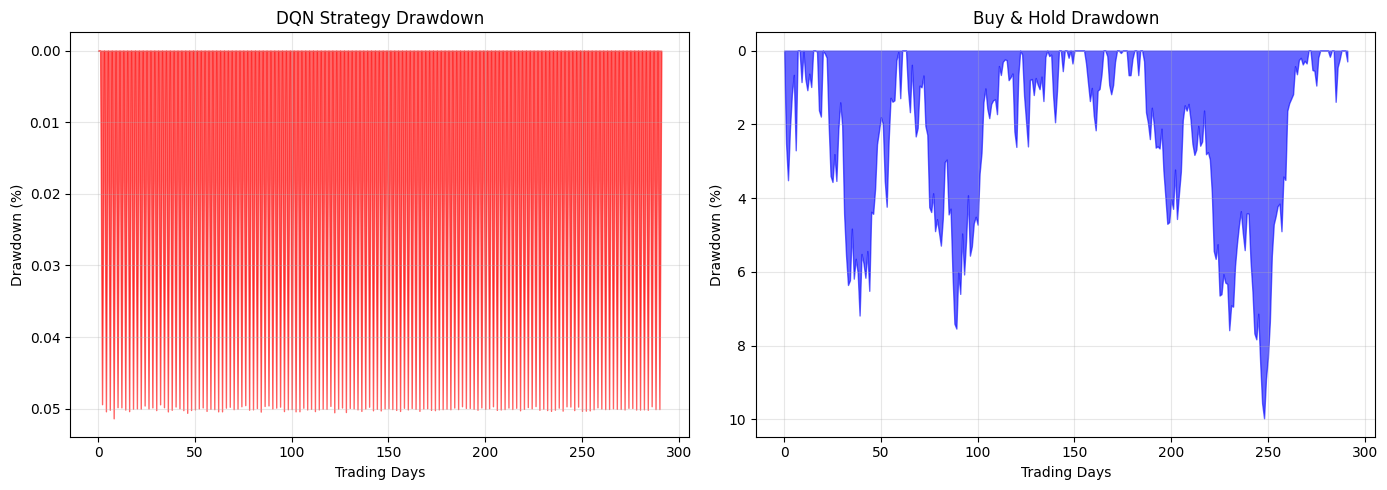


Max Drawdown - DQN: 0.05%
Max Drawdown - Buy & Hold: 9.97%


In [12]:
# Drawdown Analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# DQN Drawdown
portfolio = np.array(results['portfolio_history'])
peak = np.maximum.accumulate(portfolio)
drawdown_dqn = (peak - portfolio) / peak * 100

ax1 = axes[0]
ax1.fill_between(range(len(drawdown_dqn)), drawdown_dqn, alpha=0.6, color='red')
ax1.set_xlabel('Trading Days')
ax1.set_ylabel('Drawdown (%)')
ax1.set_title('DQN Strategy Drawdown')
ax1.invert_yaxis()
ax1.grid(True, alpha=0.3)

# Buy & Hold Drawdown
portfolio_bh = np.array(buy_hold['portfolio_history'])
peak_bh = np.maximum.accumulate(portfolio_bh)
drawdown_bh = (peak_bh - portfolio_bh) / peak_bh * 100

ax2 = axes[1]
ax2.fill_between(range(len(drawdown_bh)), drawdown_bh, alpha=0.6, color='blue')
ax2.set_xlabel('Trading Days')
ax2.set_ylabel('Drawdown (%)')
ax2.set_title('Buy & Hold Drawdown')
ax2.invert_yaxis()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nMax Drawdown - DQN: {drawdown_dqn.max():.2f}%")
print(f"Max Drawdown - Buy & Hold: {drawdown_bh.max():.2f}%")

## 8. Trade Analysis

In [13]:
# Analyze trades
if results['trades']:
    trades_df = pd.DataFrame(results['trades'])
    print("\nTrade Summary:")
    print(f"Total Trades: {len(trades_df)}")
    print(f"Buy Trades: {len(trades_df[trades_df['action'] == 'BUY'])}")
    print(f"Sell Trades: {len(trades_df[trades_df['action'] == 'SELL'])}")
    
    print("\nFirst 10 Trades:")
    print(trades_df.head(10).to_string(index=False))
else:
    print("No trades executed during backtest.")


Trade Summary:
Total Trades: 291
Buy Trades: 146
Sell Trades: 145

First 10 Trades:
 step action      price      shares
    0    BUY 367.936157  271.786281
    1   SELL 358.702332  271.786281
    2    BUY 355.008850  555.740744
    3   SELL 360.118561  555.740744
    4    BUY 363.563263 1092.046569
    5   SELL 365.524811 1092.046569
    6    BUY 357.994263 2221.828711
    7   SELL 377.667542 2221.828711
    8    BUY 381.322815 4282.146098
    9   SELL 378.079010 4282.146098


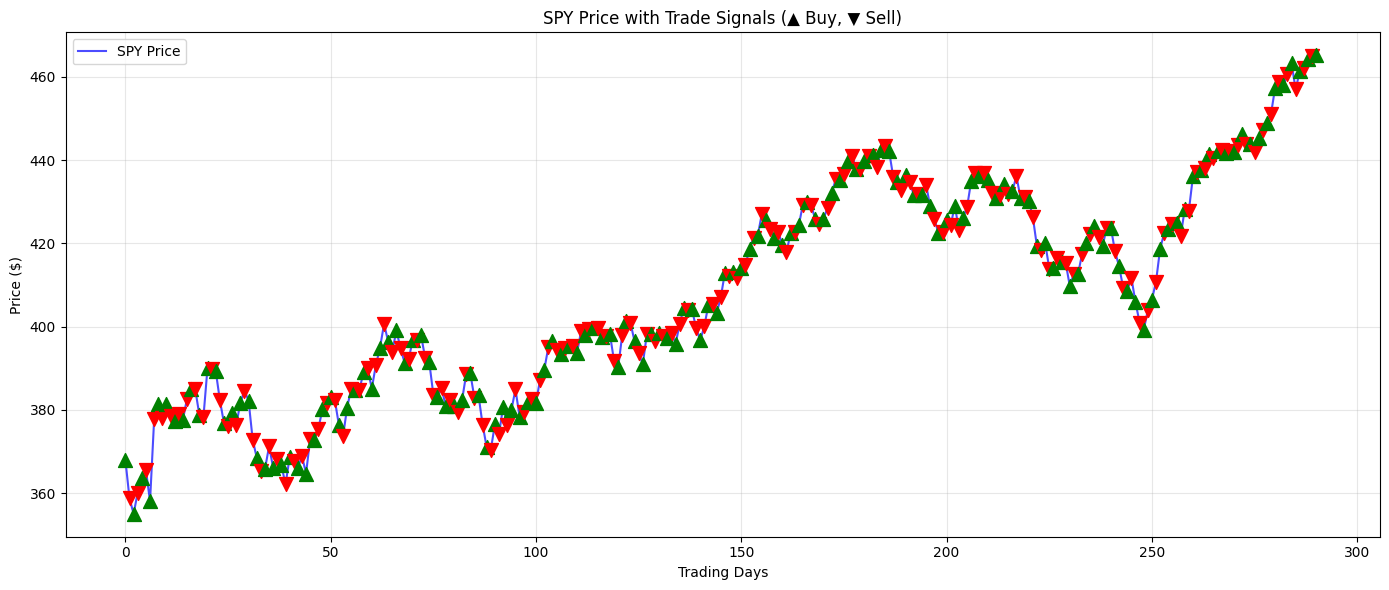

In [14]:
# Plot trades on price chart
fig, ax = plt.subplots(figsize=(14, 6))

# Plot price
prices = test_df['Close'].values
ax.plot(prices, label='SPY Price', color='blue', alpha=0.7)

# Mark trades
if results['trades']:
    for trade in results['trades']:
        step = trade['step']
        if step < len(prices):
            if trade['action'] == 'BUY':
                ax.scatter(step, prices[step], color='green', marker='^', s=100, zorder=5)
            else:
                ax.scatter(step, prices[step], color='red', marker='v', s=100, zorder=5)

ax.set_xlabel('Trading Days')
ax.set_ylabel('Price ($)')
ax.set_title('SPY Price with Trade Signals (▲ Buy, ▼ Sell)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Summary and Key Takeaways

### DQN Trading System Components
1. **Environment**: Custom trading environment with state features (returns, volatility, momentum)
2. **Agent**: Deep Q-Network with experience replay and target network
3. **Training**: Epsilon-greedy exploration with decay over 100 episodes
4. **Evaluation**: Full backtest with comprehensive performance metrics

### Potential Improvements
- **Double DQN**: Reduce overestimation bias
- **Prioritized Experience Replay**: Sample important transitions more often
- **Dueling DQN**: Separate value and advantage streams
- **More Features**: Add volume, sentiment, macro indicators
- **Risk Management**: Position sizing, stop-loss integration
- **Hyperparameter Tuning**: Learning rate, network architecture, reward shaping

In [15]:
# Final Summary
print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)
print(f"\nTest Period: {test_df.index[0].strftime('%Y-%m-%d')} to {test_df.index[-1].strftime('%Y-%m-%d')}")
print(f"Initial Capital: $100,000")
print(f"\nDQN Strategy:")
print(f"  - Final Value: ${results['stats']['final_value']:,.2f}")
print(f"  - Total Return: {results['stats']['total_return']:.2%}")
print(f"  - Sharpe Ratio: {results['stats']['sharpe_ratio']:.2f}")
print(f"\nBuy & Hold Benchmark:")
print(f"  - Final Value: ${buy_hold['final_value']:,.2f}")
print(f"  - Total Return: {buy_hold['total_return']:.2%}")
print(f"  - Sharpe Ratio: {buy_hold['sharpe_ratio']:.2f}")

outperformance = results['stats']['total_return'] - buy_hold['total_return']
print(f"\nStrategy Outperformance: {outperformance:+.2%}")
print("="*60)


FINAL SUMMARY

Test Period: 2022-11-01 to 2023-12-29
Initial Capital: $100,000

DQN Strategy:
  - Final Value: $8,100,153,364,446,635,449,391,121,429,498,315,725,926,180,061,184.00
  - Total Return: 8100153364446635216143410987504105850532790272.00%
  - Sharpe Ratio: 15.88

Buy & Hold Benchmark:
  - Final Value: $126,066.24
  - Total Return: 26.07%
  - Sharpe Ratio: 1.41

Strategy Outperformance: +8100153364446635216143410987504105850532790272.00%
